In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.grid'] = False
plt.style.context('Solarize_Light2')

roots = [3.64095690650721,
        3.5184492410503965,
        3.393522159945615,
        3.2659503538230608,
        3.1354715107049764,
        3.0017774197047054,
        2.8645022087095424,
        2.7232065461969945,
        2.577356059664392,
        2.426291319035178,
        2.2691853142129728, 
        2.104982167992544, 
        1.932307699120554,
        1.749339162933206, 
        1.5536238493280832, 
        1.34187327905057, 
        1.109960313758399, 
        0.8541630993606272, 
        0.5762735442012712, 
        0.2885386111960936, 
        0.03198372863548067]
jds = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))
num_temps = 100
num_epochs = 3

In [23]:
def errs(errs):
    return np.array([sum(errs[i*512:(i+1)*512])/512 for i in range(num_temps)])

def stds_outs(outs):
    return np.power(np.array([np.std(outs[i*512:(i+1)*512]) for i in range(num_temps)]), 2)

In [24]:
df_res = pd.DataFrame(columns=['Jd', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])

In [25]:
Jd = 1.0
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

errs_ = []
outs_ = []
Ls = [20, 30, 60, 80]
#epochs = [3] * len(Ls)

for i, L in enumerate(Ls):
    with open(f'data_errors/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
        errs_.append(np.load(f)) 
    with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
        outs_.append(np.squeeze(np.load(f)))

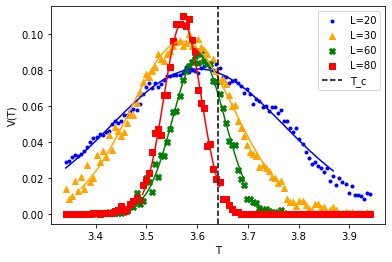

In [26]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(x, y):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, maxfev=100000)
    return popt, pcov

def gaussian_fit_with_p(x, y, p):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, p0=p, maxfev=1000000)
    return popt, pcov

#p_ = [[np.max(errs(errs_[j])), T[np.argmax(errs(errs_[j]))], np.std(errs(errs_[j])) / 2] for j in range(len(Ls))]
p_ = [[np.max(stds_outs(outs_[j][:, 0])), T[np.argmax(stds_outs(outs_[j][:, 0]))], np.std(stds_outs(outs_[j][:, 0])) / 2] for j in range(len(Ls))]


#data = [stds_outs(outs_[j][:, 0]) for j in range(len(Ls))]

# if Jd in [0.0625, 0.125]:
#     threshold = 0.1
# else:
#     threshold = 0.05

# threshold = [0.1, 0.1, 0.05, 0.05, 0.01]
threshold = [0.02, 0.02, 0.01, 0.01, 0.005]
# threshold = [0.0, 0.0, 0.0, 0.0, 0.0]

data = [stds_outs(outs_[j][:, 0])[stds_outs(outs_[j][:, 0]) > threshold[j]] for j in range(len(Ls))]
temp = [T[stds_outs(outs_[j][:, 0]) > threshold[j]] for j in range(len(Ls))]


#tmp = [gaussian_fit_with_p(y=errs(errs_[j]), x=T, p=p_[j]) for j in range(len(Ls))]
tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_ = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_ = np.array([tmp[j][1] for j in range(len(Ls))])

with open(f'var_params/triangular/popt_{Jd}.npy', 'wb') as f:
    np.save(f, popt_)

with open(f'var_params/triangular/pcov_{Jd}.npy', 'wb') as f:
    np.save(f, pcov_)


plt.figure()

markers=['.', '^', 'X', 's', '*']
colors=['blue', 'orange', 'green', 'red', 'm']

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_[j][0], popt_[j][1], popt_[j][2]), c=colors[j])
    plt.scatter(T, stds_outs(outs_[j][:, 0]), marker=markers[j], c=colors[j], label=f'L={Ls[j]}')
    
    #plt.scatter(T, stds_outs(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

plt.axvline(x=T_c, color='black', linestyle='--', label='T_c')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

#plt.title(f'Jd = {Jd}')
plt.xlabel('T')
plt.ylabel('V(T)')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [27]:
perr_ = np.array([np.sqrt(np.diag(pcov_[j, :])) for j in range(len(Ls))])
popt_, perr_

(array([[0.03462272, 3.6009347 , 0.17148712],
        [0.02453053, 3.57058619, 0.10200983],
        [0.0112528 , 3.60296781, 0.05100317],
        [0.00987655, 3.57118285, 0.03683158]]),
 array([[0.00024998, 0.00125165, 0.00160714],
        [0.00025647, 0.00116117, 0.00133104],
        [0.00016057, 0.00081222, 0.00088752],
        [0.00019609, 0.00082742, 0.00087491]]))

In [28]:
df = pd.DataFrame(columns=['Jd', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])
df['Jd'] = [Jd]*len(Ls)
df['L'] = [20,30,60,80]

mus = []
for i in range(popt_[:, 1].shape[0]):
    mus.append(str(round(popt_[i, 1], 4)) + '(' + str(round(perr_[i, 1], 4)) + ')')
    
df['\mu'] = mus 
df['T_c'] = np.round([T_c]*len(Ls), 3)

sigmas = []
for i in range(popt_[:, 2].shape[0]):
    sigmas.append(str(round(popt_[i, 2], 4)) + '(' + str(round(perr_[i, 2], 4)) + ')')
    
df['\sigma'] = sigmas

In [29]:
df

,Jd,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,1.0,20,3.6009(0.0013),3.641,0.1715(0.0016),NaN,NaN
1,1.0,30,3.5706(0.0012),3.641,0.102(0.0013),NaN,NaN
2,1.0,60,3.603(0.0008),3.641,0.051(0.0009),NaN,NaN
3,1.0,80,3.5712(0.0008),3.641,0.0368(0.0009),NaN,NaN


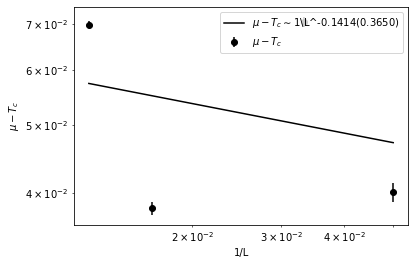

In [30]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80]])
#cs_ = np.array(popt_)[:, 1]  # mu 
cs_ = np.abs(np.array(popt_)[:, 1] - T_c) # mu - tc

pl_, pcov_ = line_fit(y=np.log(np.abs(cs_)), x=np.log(ls))

perr_line = np.sqrt(np.diag(pcov_))

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs_, yerr=perr_[:, 1], fmt="o", color='black', label='$\mu-T_c$')

plt.plot(ls, np.exp(line(np.log(ls), pl_[0], pl_[1])), color='black', label='$\mu-T_c\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_[0], 4), round(perr_line[0], 4)))

#plt.title(f'Jd = {Jd}')
plt.xlabel('1/L')
plt.ylabel('$\mu-T_c$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.savefig(f'images/{Jd}-mu.png')

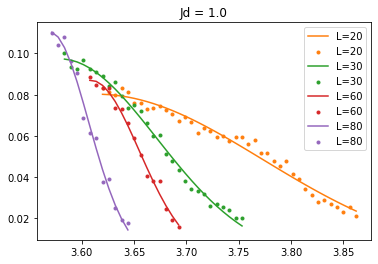

In [31]:
data = []

for j in range(len(Ls)):
    dt = stds_outs(outs_[j][:, 0])[T >= T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]] 
    data.append(dt[dt >= threshold[j]])
temp = [T[T >= T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]


p_ = [[np.max(stds_outs(outs_[j][:, 0])), T[np.argmax(stds_outs(outs_[j][:, 0]))], np.std(stds_outs(outs_[j][:, 0])) / 2] for j in range(len(Ls))]

#tmp = [gaussian_fit_with_p(y=errs(errs_[j]), x=T, p=p_[j]) for j in range(len(Ls))]
tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_r = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_r = np.array([tmp[j][1] for j in range(len(Ls))])

plt.figure()

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_r[j][0], popt_r[j][1], popt_r[j][2]), label=f'L={Ls[j]}', c=f'C{j+1}')
    plt.scatter(temp[j], data[j], label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    
    #plt.scatter(T, stds_outs(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

#plt.axvline(x=T_c, color='black', linestyle='--')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

plt.title(f'Jd = {Jd}')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [32]:
perr_r = np.array([np.sqrt(np.diag(pcov_r[j, :])) for j in range(len(Ls))])

popt_r, perr_r
# for j in range(len(Ls)):
#     print(popt_[j, 2], perr_[j, 2])

(array([[0.03182129, 3.61432967, 0.15824627],
        [0.02242654, 3.57938718, 0.09191345],
        [0.01008039, 3.60866731, 0.0462398 ],
        [0.01021719, 3.56946918, 0.03691782]]),
 array([[0.00223012, 0.01174302, 0.0084362 ],
        [0.0011848 , 0.00540494, 0.00351927],
        [0.00072325, 0.00368112, 0.00259693],
        [0.00113563, 0.0046471 , 0.00301057]]))

In [33]:
sigmas = []
for i in range(popt_r[:, 2].shape[0]):
    sigmas.append(str(round(popt_r[i, 2], 4)) + '(' + str(round(perr_r[i, 2], 4)) + ')')
    
df['\sigma_r'] = sigmas
df

,Jd,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,1.0,20,3.6009(0.0013),3.641,0.1715(0.0016),0.1582(0.0084),NaN
1,1.0,30,3.5706(0.0012),3.641,0.102(0.0013),0.0919(0.0035),NaN
2,1.0,60,3.603(0.0008),3.641,0.051(0.0009),0.0462(0.0026),NaN
3,1.0,80,3.5712(0.0008),3.641,0.0368(0.0009),0.0369(0.003),NaN


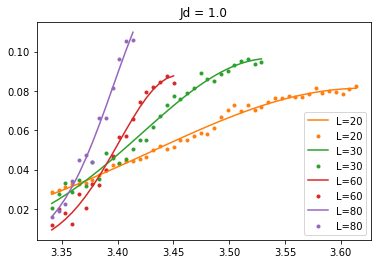

In [34]:
data = []

for j in range(len(Ls)):
    dt = stds_outs(outs_[j][:, 0])[T < T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]] 
    data.append(dt[dt >= threshold[j]])
temp = [T[T < T[np.argmin(np.abs(stds_outs(outs_[j][:, 0]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]


p_ = [[np.max(data[j]), T[np.argmax(stds_outs(outs_[j][:, 0]))], np.std(data[j])] for j in range(len(Ls))]

tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_l = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_l = np.array([tmp[j][1] for j in range(len(Ls))])

plt.figure()

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_l[j][0], popt_l[j][1], popt_l[j][2]), label=f'L={Ls[j]}', c=f'C{j+1}')
    plt.scatter(temp[j], data[j], label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    
    #plt.scatter(T, stds_outs(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

#plt.axvline(x=T_c, color='black', linestyle='--')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

plt.title(f'Jd = {Jd}')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [35]:
perr_l = np.array([np.sqrt(np.diag(pcov_l[j, :])) for j in range(len(Ls))])

popt_l, perr_l
# for j in range(len(Ls)):
#     print(popt_[j, 2], perr_[j, 2])

(array([[0.03866456, 3.62051949, 0.1894771 ],
        [0.02799155, 3.5375327 , 0.11559532],
        [0.01170819, 3.45370849, 0.05316671],
        [0.01774073, 3.44802857, 0.05162982]]),
 array([[0.00160767, 0.00817064, 0.00608042],
        [0.00220122, 0.00987069, 0.00658279],
        [0.00126857, 0.00653572, 0.00406407],
        [0.00753963, 0.02286537, 0.00974234]]))

In [36]:
sigmas = []
for i in range(popt_r[:, 2].shape[0]):
    sigmas.append(str(round(popt_l[i, 2], 4)) + '(' + str(round(perr_l[i, 2], 4)) + ')')
    
df['\sigma_l'] = sigmas
df

,Jd,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,1.0,20,3.6009(0.0013),3.641,0.1715(0.0016),0.1582(0.0084),0.1895(0.0061)
1,1.0,30,3.5706(0.0012),3.641,0.102(0.0013),0.0919(0.0035),0.1156(0.0066)
2,1.0,60,3.603(0.0008),3.641,0.051(0.0009),0.0462(0.0026),0.0532(0.0041)
3,1.0,80,3.5712(0.0008),3.641,0.0368(0.0009),0.0369(0.003),0.0516(0.0097)


In [37]:
df_res = pd.concat([df_res,df])
df_res

,Jd,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,1.0,20,3.6009(0.0013),3.641,0.1715(0.0016),0.1582(0.0084),0.1895(0.0061)
1,1.0,30,3.5706(0.0012),3.641,0.102(0.0013),0.0919(0.0035),0.1156(0.0066)
2,1.0,60,3.603(0.0008),3.641,0.051(0.0009),0.0462(0.0026),0.0532(0.0041)
3,1.0,80,3.5712(0.0008),3.641,0.0368(0.0009),0.0369(0.003),0.0516(0.0097)


In [38]:
print(df_res.to_latex(index=False)) 

\begin{tabular}{lllllll}
\toprule
  Jd &  L &            \textbackslash mu &    T\_c &         \textbackslash sigma &       \textbackslash sigma\_r &       \textbackslash sigma\_l \\
\midrule
 1.0 & 20 & 3.6009(0.0013) &  3.641 & 0.1715(0.0016) & 0.1582(0.0084) & 0.1895(0.0061) \\
 1.0 & 30 & 3.5706(0.0012) &  3.641 &  0.102(0.0013) & 0.0919(0.0035) & 0.1156(0.0066) \\
 1.0 & 60 &  3.603(0.0008) &  3.641 &  0.051(0.0009) & 0.0462(0.0026) & 0.0532(0.0041) \\
 1.0 & 80 & 3.5712(0.0008) &  3.641 & 0.0368(0.0009) &  0.0369(0.003) & 0.0516(0.0097) \\
\bottomrule
\end{tabular}



In [39]:
cs_

array([0.04002221, 0.07037072, 0.0379891 , 0.06977405])

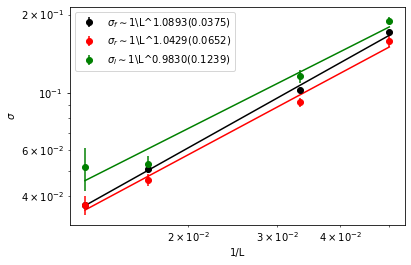

In [40]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80]])
cs_ = np.abs(np.array(popt_)[:, 2]) # sigma 
cs_r = np.abs(np.array(popt_r)[:, 2]) # sigma 
cs_l = np.abs(np.array(popt_l)[:, 2]) # sigma 

pl_, pcov_ = line_fit(y=np.log(np.abs(cs_)), x=np.log(ls))
pl_r, pcov_r = line_fit(y=np.log(np.abs(cs_r)), x=np.log(ls))
pl_l, pcov_l = line_fit(y=np.log(np.abs(cs_l)), x=np.log(ls))
#pl_00 = np.polyfit(np.log(ls), np.log(cs), 1)

perr_line = np.sqrt(np.diag(pcov_))
perr_r_line = np.sqrt(np.diag(pcov_r))
perr_l_line = np.sqrt(np.diag(pcov_l))

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs_, yerr=perr_[:, 2], fmt="o", color='black', label='$\sigma_f\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_[0], 4), round(perr_line[0], 4)))
plt.errorbar(ls, cs_r, yerr=perr_r[:, 2], fmt="o", color='red', label='$\sigma_r\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_r[0], 4), round(perr_r_line[0], 4)))
plt.errorbar(ls, cs_l, yerr=perr_l[:, 2], fmt="o", color='green', label='$\sigma_l\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_l[0], 4), round(perr_l_line[0], 4)))
#plt.plot(ls, np.exp(np.poly1d(pl_00)(np.log(ls))))

plt.plot(ls, np.exp(line(np.log(ls), pl_[0], pl_[1])), color='black')
plt.plot(ls, np.exp(line(np.log(ls), pl_r[0], pl_r[1])), color='red')
plt.plot(ls, np.exp(line(np.log(ls), pl_l[0], pl_l[1])), color='green')

#plt.title(f'Jd = {Jd}')
plt.xlabel('1/L')
plt.ylabel('$\sigma$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(f'images/{Jd}-sigmas-ferr.png')

In [39]:
pl_, pcov_

(array([1.07118651, 1.69552412]),
 array([[9.21626556e-05, 3.42690726e-04],
        [3.42690726e-04, 1.30199037e-03]]))

In [40]:
perr_ = np.sqrt(np.diag(pcov_))
perr_

array([0.00960014, 0.0360831 ])